# Mixture Density Network (MDN)

The goal of this notebook is to test the implementation of Gaussian MDN in jax.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload

jax.config.update("jax_enable_x64", True)

## Simulation model

In [2]:
sbibm.get_available_tasks()

['bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'gaussian_mixture',
 'lotka_volterra',
 'sir',
 'slcp',
 'two_moons',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [3]:
task = sbibm.get_task('gaussian_mixture')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]

2024-01-30 16:59:40.215717: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


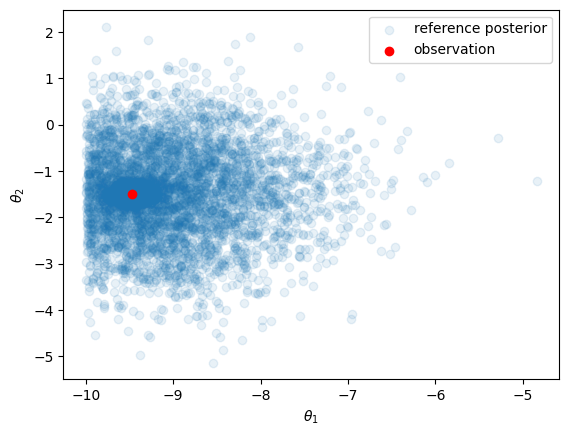

In [4]:
plt.figure()

# plot real posterior
plt.scatter(reference_samples[:, 0], reference_samples[:, 1], alpha=0.1, label='reference posterior')
plt.scatter(observation[:, 0], observation[:, 1], c='r', label='observation')

plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.legend()

plt.show()

## Neural posterior estimation using Gaussian MDN

In [27]:
%load_ext autoreload

%autoreload 2
import normflow.model
from normflow.distribution import MixtureDensityDistribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
NF_mdn = MixtureDensityDistribution(
    n_data=dim,
    n_components=3,
    layers=[128, 128],
    activation = jax.nn.silu
)

In [29]:
seed = jax.random.PRNGKey(0)

params = NF_mdn.md_model.init(seed, jnp.zeros((1, dim)))

(1, 18)


In [31]:
key = jax.random.PRNGKey(42)

batch_size = 54

thetas = prior(num_samples=batch_size)
xs = simulator(thetas)
thetas, xs = jnp.array(thetas), jnp.array(xs)

NF_mdn.log_prob(params, thetas, xs)

(54, 18)
tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[54], event_shape=[2], dtype=float32)


Array([ -7.8789234,  -3.9568775,  -9.170205 , -11.487173 ,  -6.580263 ,
       -10.770897 ,  -6.620353 ,  -6.5768   , -10.031496 ,  -6.056238 ,
        -5.158886 , -12.023399 , -15.555618 ,  -7.029414 , -25.753412 ,
        -6.12433  ,  -8.799791 ,  -3.7626429,  -5.910235 ,  -5.754834 ,
        -4.8147182, -54.02278  ,  -4.7932076,  -4.614099 ,  -5.6648664,
        -2.6101143, -10.061761 ,  -7.422936 ,  -5.2991486,  -6.604875 ,
       -10.699192 ,  -5.845963 ,  -7.4608173,  -6.826033 ,  -6.8517137,
        -5.045601 , -22.604296 ,  -7.101095 ,  -8.583166 ,  -5.449677 ,
        -6.8174834,  -5.316554 , -11.614727 ,  -7.044625 , -10.197834 ,
        -8.537742 ,  -6.683798 ,  -7.5730877,  -6.2083983, -10.514962 ,
        -4.5541883,  -6.5084524,  -9.929754 ,  -6.6219997], dtype=float32)

In [22]:
samples = NF_mdn.sample(params, xs, n_samples=100000, key=key)

key, subkey = jax.random.split(key)

tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[128], event_shape=[2], dtype=float32)


In [10]:
samples.shape

(100000, 128, 2)

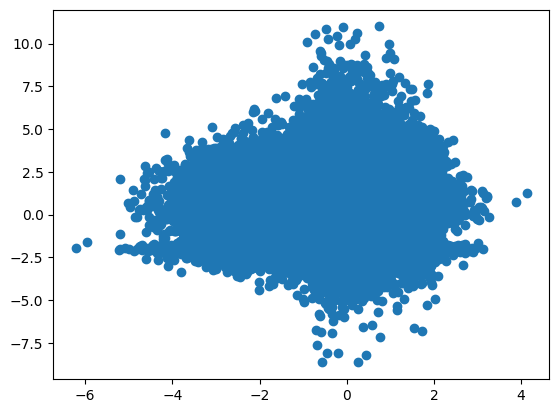

In [12]:
plt.figure()

plt.scatter(samples[:,0], samples[:, 1])
plt.show()

In [23]:
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

In [24]:
#negative log_likelihood
def loss_nll(params, mu, batch):
    return -jnp.mean(NF_mdn.log_prob(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step"""
    loss, grads = jax.value_and_grad(loss_nll)(
        params, mu, batch
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [25]:
batch_size = 128
thetas = prior(num_samples=batch_size)
xs = simulator(thetas)

loss_nll(params, jnp.array(thetas), jnp.array(xs))

tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[128], event_shape=[2], dtype=float32)


Array(10.185078, dtype=float32)

In [26]:
from tqdm import tqdm

batch_size = 128
batch_loss = []
pbar = tqdm(range(10000))

for batch in pbar:
    thetas = prior(num_samples=batch_size)
    xs = simulator(thetas)
    
    l, params, opt_state = update(
        params, opt_state, jnp.array(thetas, dtype=jnp.float64), jnp.array(xs, dtype=jnp.float64)
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    

  0%|          | 0/10000 [00:00<?, ?it/s]

tfp.distributions.MixtureSameFamily("MixtureSameFamily", batch_shape=[128], event_shape=[2], dtype=float64)


loss 2.480:  39%|███▉      | 3947/10000 [00:09<00:14, 420.46it/s]


KeyboardInterrupt: 

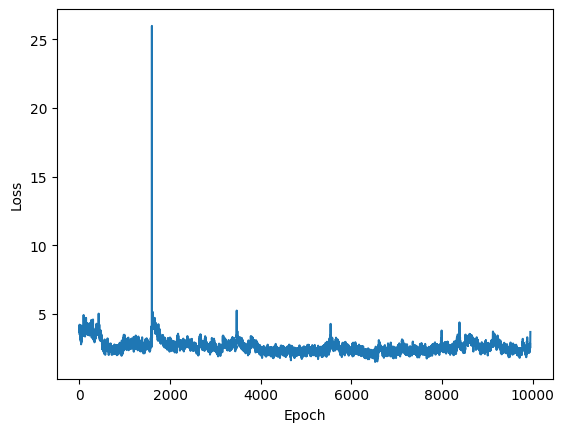

In [66]:
plt.figure()

plt.plot(batch_loss[50:])

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Results

In [67]:
from chainconsumer import ChainConsumer

In [74]:
num_samples = 100000

sample_nd = NF_mdn.sample(
    params,
    y=observation,
    n_samples = num_samples,
    key = key
)

key, subkey = jax.random.split(key)

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(sample_nd, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

ValueError: weights should have the same shape as a.

In [76]:
sample_nd.shape

(100000, 1, 2)

Array([[[ -0.7014365 ,  -2.964619  ],
        [ -2.7109628 ,   0.4689814 ],
        [ -1.746696  ,  -6.1717825 ],
        ...,
        [  3.9259186 ,  12.528389  ],
        [ -0.35012704,  -2.1314304 ],
        [ -1.1462806 , -17.45303   ]],

       [[ -0.10287237, -10.637934  ],
        [ -0.15866011,   3.452419  ],
        [  2.303082  ,  -2.289301  ],
        ...,
        [ -0.58553886,   3.8455346 ],
        [  0.82786465,   6.7475686 ],
        [  8.575741  ,   6.6553564 ]],

       [[ -2.0813842 ,   6.050926  ],
        [ -0.2512648 ,   5.1238594 ],
        [ -1.493381  ,  -5.5325756 ],
        ...,
        [ -2.684616  ,  -3.053165  ],
        [ -3.600565  ,  -2.462571  ],
        [  7.4077835 ,  -4.9778614 ]],

       ...,

       [[-18.295431  ,   0.04291701],
        [ -0.44814396,  -2.3211703 ],
        [  2.067162  ,  -5.113899  ],
        ...,
        [  2.7952805 ,  -3.6733444 ],
        [ -0.5306254 ,   0.39222908],
        [ -7.25319   ,  -6.2460675 ]],

       [[ -4.46